In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
from time import time

import tensorflow as tf
from tensorflow import keras

from useful_functions import load_transform_split, color_scatter, scatter_predvreal, get_metric, plot_performance, ann_fit
from RandomSeedSearchCV import RandomSeedSearchCV, randomseed_ann_maker

from joblib import dump,load

In [4]:
X_train,X_test,y_train,y_test,w_train,w_test,pipeline = load_transform_split(target='DROPOUT_N',
                                                              weight='COHORT_CNT',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='numpy',
                                                              random_state=42)

wmax = np.max([np.max(w_train),np.max(w_test)])
w_train /= wmax
w_test  /= wmax
w_train = 1 - (1-0.3)*(1-w_train)
w_test = 1 - (1-0.3)*(1-w_test)
print(min(w_train),max(w_train))

0.30285714285714294 0.9771428571428572


In [9]:
#CAUTION: This cell takes awhile unless you make N small.

optimizer = keras.optimizers.Adam()
#Searching through neural net models.
tbl = RandomSeedSearchCV(randomseed_ann_maker,X_train,y_train,w_train=w_train,N=50,cv=1,
                         input_shape=[X_train.shape[1]],
                         output_shape=1,output_activation='relu',
                         loss='mean_squared_error',optimizer=optimizer,
                         custom_fit = ann_fit,
                         fit_params={'epochs':15,'bail_init_loss':1.9,'verbose':False})
print(tbl)



KeyboardInterrupt: 

In [33]:
#Get best model.
best_seed = int(tbl[3,0])
best_model = randomseed_ann_maker(best_seed,input_shape=[X_train.shape[1]],
                                  output_shape=1,output_activation='relu',
                                  loss='mean_squared_error',optimizer=optimizer)

In [34]:
best_model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1691 (Dense)           (None, 19)                380       
_________________________________________________________________
dense_1692 (Dense)           (None, 18)                360       
_________________________________________________________________
dense_1693 (Dense)           (None, 16)                304       
_________________________________________________________________
dense_1694 (Dense)           (None, 14)                238       
_________________________________________________________________
dense_1695 (Dense)           (None, 12)                180       
_________________________________________________________________
dense_1696 (Dense)           (None, 12)                156       
_________________________________________________________________
dense_1697 (Dense)           (None, 11)              

In [35]:
for layer in best_model.layers:
    print(layer.activation)

<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function tanh at 0x7f8126df6170>
<function relu at 0x7f8126df60e0>


In [38]:
best_model.fit(X_train,y_train,epochs=20,sample_weight=w_train)

Train on 57656 samples
Epoch 1/20
57656/57656 [==============================] - 10s 174us/sample - loss: 0.9003
Epoch 2/20
57656/57656 [==============================] - 11s 184us/sample - loss: 0.9255
Epoch 3/20
57656/57656 [==============================] - 11s 188us/sample - loss: 0.9002
Epoch 4/20
57656/57656 [==============================] - 11s 193us/sample - loss: 0.8845
Epoch 5/20
57656/57656 [==============================] - 11s 194us/sample - loss: 0.8999
Epoch 6/20
57656/57656 [==============================] - 10s 177us/sample - loss: 0.8814
Epoch 7/20
57656/57656 [==============================] - 10s 171us/sample - loss: 0.8734
Epoch 8/20
57656/57656 [==============================] - 10s 181us/sample - loss: 0.8616
Epoch 9/20
57656/57656 [==============================] - 12s 205us/sample - loss: 0.8574
Epoch 10/20
57656/57656 [==============================] - 11s 191us/sample - loss: 0.8554
Epoch 11/20
57656/57656 [==============================] - 11s 186us/sample 

In [10]:
mse = get_metric('mean_squared_error')

print("Best RFR: Train RMSE = %.2f, Test RMSE = %.2f"%(
                               np.sqrt(mse(best_model,X_train,y_train)),
                               np.sqrt(mse(best_model,X_test,y_test)),
                               ))

Best RFR: Train RMSE = 1.38, Test RMSE = 1.44


In [11]:
#Store random search output and pickle best model.
#np.savetxt("trial1_ANN_randomseedsearch.out",tbl,header='seed  training_mse  validation_mse  training_time(s)')
#best_model.save('saved_models/trial1_best_ann_DROPOUT_N.h5') 

<IPython.core.display.Javascript object>


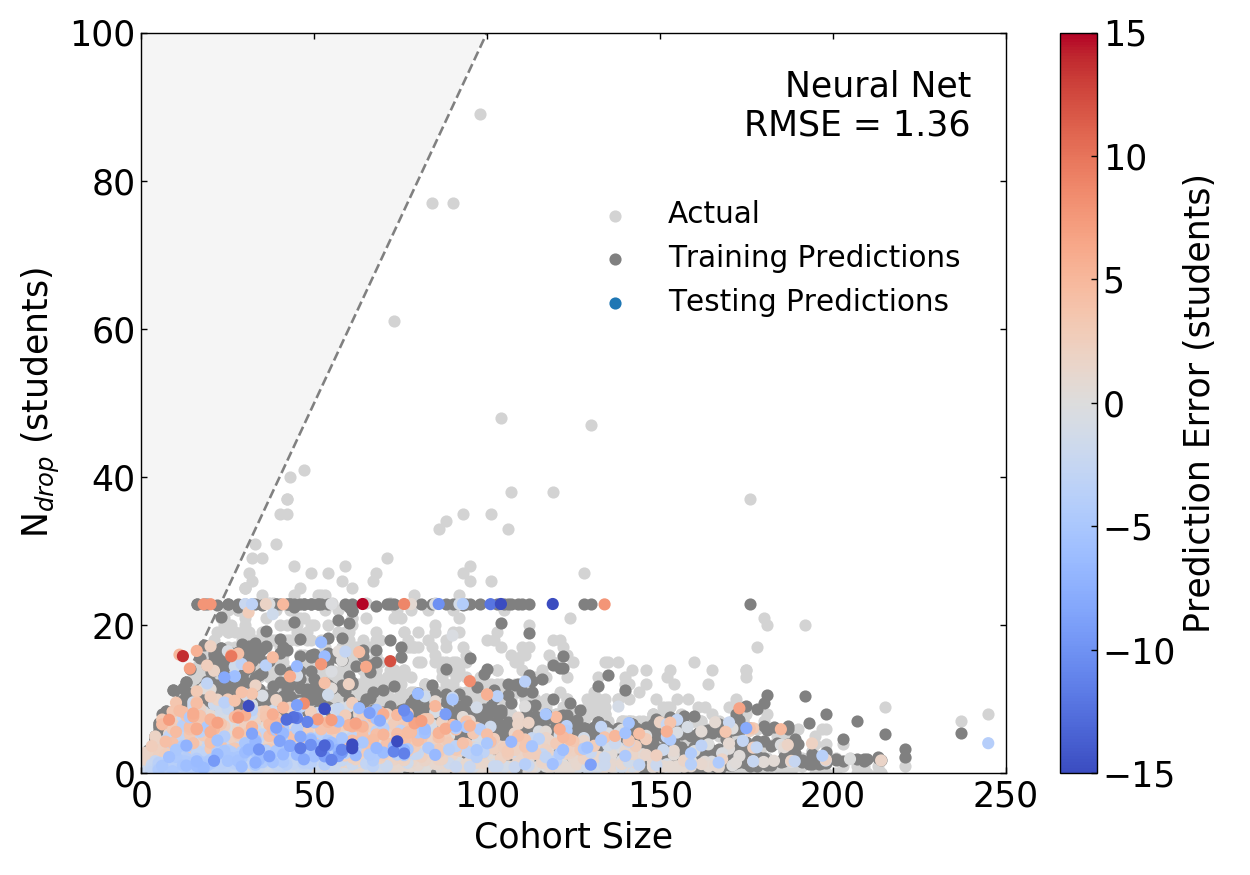

In [39]:
#Make a pretty plot
plt.rcParams.update({
                     'xtick.direction':'in',
                     'xtick.top':True,
                     'xtick.bottom':True,
                     'ytick.direction':'in',
                     'ytick.right':True,
                     'ytick.left':True,
})

#rfr = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')
ann = best_model
ax = plot_performance(ann,'Neural Net',X_train,X_test,y_train,y_test)

plt.tight_layout()
#ax.figure.savefig('figures/trial2_best_ann_summary.png',dpi=450)

In [14]:
best_model = randomseed_ann_maker(5,input_shape=[X_train.shape[1]],
                                  output_shape=1,output_activation='relu',
                                  loss='mean_squared_error',optimizer=optimizer)
history = best_model.fit(X_train,y_train,epochs=1)
best_model.summary()

Train on 57656 samples
57656/57656 [==============================] - 25s 440us/sample - loss: 3.2937
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 6)                 120       
_________________________________________________________________
dense_25 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_26 (Dense)             (None, 14)                266       
_________________________________________________________________
dense_27 (Dense)             (None, 9)                 135       
_________________________________________________________________
dense_28 (Dense)             (None, 15)                150       
_________________________________________________________________
dense_29 (Dense)             (None, 11)                176       
__________________

In [22]:
history = best_model.fit(X_train,y_train,epochs=1)

Train on 57656 samples
57656/57656 [==============================] - 17s 291us/sample - loss: 2.6203


In [21]:
history.history['loss']

[2.8101285882030558]

In [13]:
best_model.predict(X_test[:1,:])

array([[-0.]], dtype=float32)

In [7]:
reinit_ann(best_model)

AttributeError: module 'tensorflow' has no attribute 'variables_initializer'

In [12]:
best_model.reset_states()

In [17]:
best_model = randomseed_ann_maker(8,input_shape=[X_train.shape[1]],
                                  output_shape=1,output_activation='relu',
                                  loss='mean_squared_error',optimizer=optimizer,cone=True)
best_model.summary()

START: 2
LAYER 20 0
18 2 9
20 11
LAYER 11 1
9 1 9
11 2
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 11)                220       
_________________________________________________________________
dense_111 (Dense)            (None, 3)                 36        
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 4         
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________


In [6]:
from sklearn.metrics import mean_squared_error
model1 = keras.models.load_model('saved_models/better_neural_net.h5')
model2 = keras.models.load_model('saved_models/weighted_neuralnet_attempt1.h5')
ypred1 = model1.predict(X_test)
ypred2 = model2.predict(X_test)
mse1 = mean_squared_error(y_test, ypred1)
mse2 = mean_squared_error(y_test, ypred2)
print('No weights RMSE:   %.3f' %np.sqrt(mse1))
print('With weights RMSE: %.3f' %np.sqrt(mse2))

No weights RMSE:   1.381
With weights RMSE: 1.305


<IPython.core.display.Javascript object>


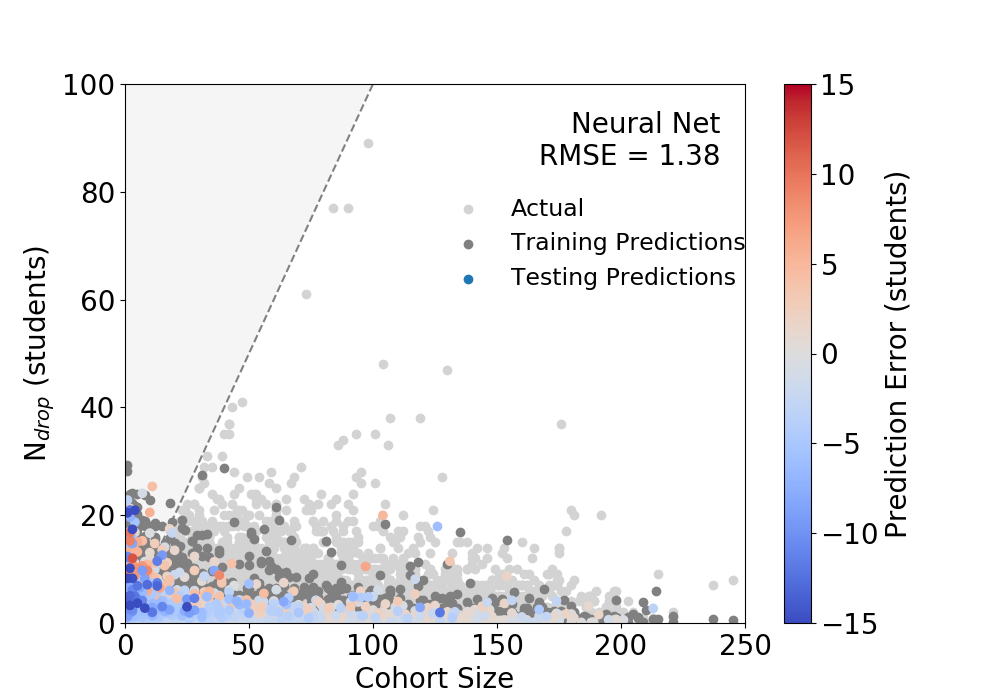

In [7]:
ax = plot_performance(model1,'Neural Net',X_train,X_test,y_train,y_test,random_state=24)
#ax.figure.savefig('figures/weighted_neuralnet_attempt1_summary.png',dpi=450)

<IPython.core.display.Javascript object>


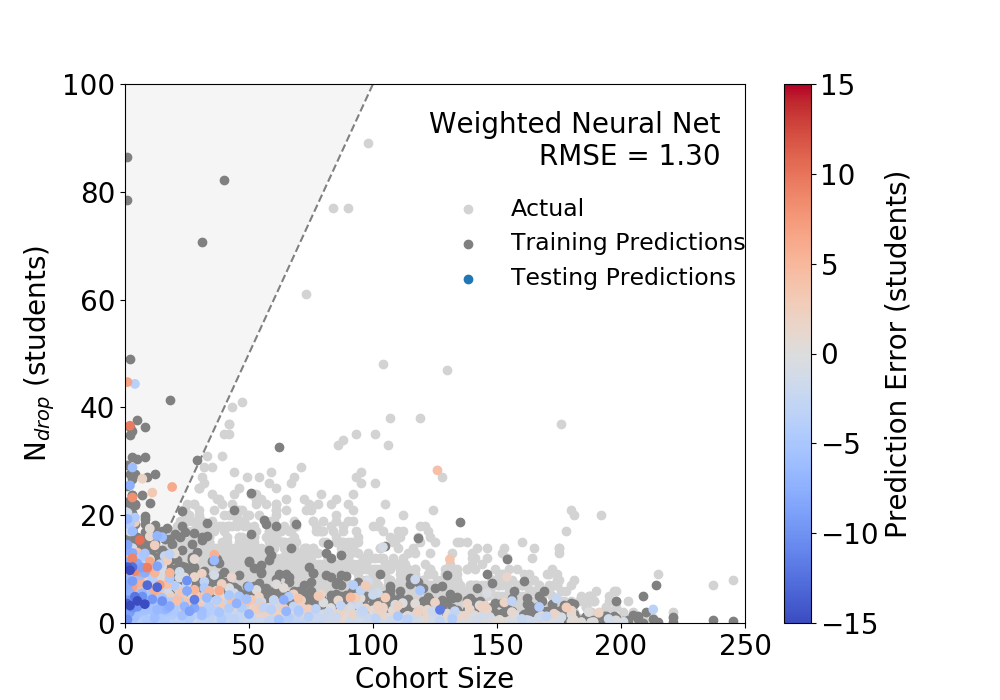

In [9]:
ax = plot_performance(model2,'Weighted Neural Net',X_train,X_test,y_train,y_test,random_state=24)

In [10]:
history = model2.fit(X_train, y_train, sample_weight=w_train, epochs=50)

  ...
    to  
  ['...']
Train on 57656 samples
Epoch 1/50
57656/57656 [==============================] - 4s 70us/sample - loss: 0.7063
Epoch 2/50
57656/57656 [==============================] - 3s 59us/sample - loss: 0.6977
Epoch 3/50
57656/57656 [==============================] - 3s 54us/sample - loss: 0.6991
Epoch 4/50
57656/57656 [==============================] - 3s 54us/sample - loss: 0.6910
Epoch 5/50
57656/57656 [==============================] - 3s 55us/sample - loss: 0.6847
Epoch 6/50
57656/57656 [==============================] - 3s 55us/sample - loss: 0.6850
Epoch 7/50
57656/57656 [==============================] - 3s 57us/sample - loss: 0.6805
Epoch 8/50
57656/57656 [==============================] - 3s 56us/sample - loss: 0.6815
Epoch 9/50
57656/57656 [==============================] - 3s 56us/sample - loss: 0.6804
Epoch 10/50
57656/57656 [==============================] - 3s 56us/sample - loss: 0.6838
Epoch 11/50
57656/57656 [==============================] - 3s 56us/samp

<IPython.core.display.Javascript object>


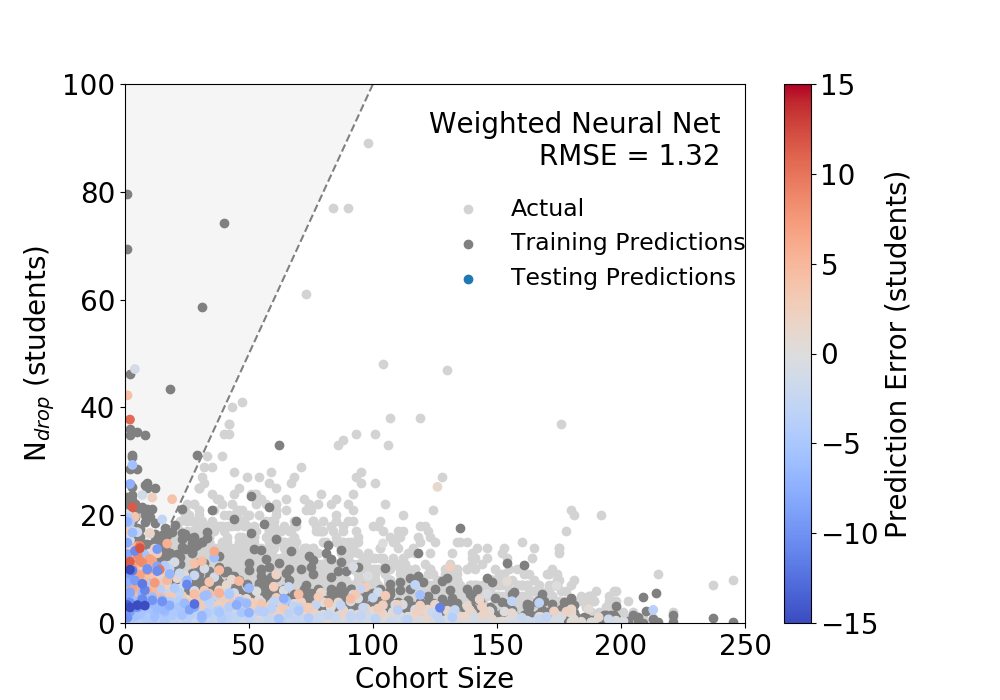

In [11]:
ax = plot_performance(model2,'Weighted Neural Net',X_train,X_test,y_train,y_test,random_state=24)